In [1]:
include("../functions.jl")
include("../plotting_functions.jl")
using LaTeXStrings
using JLD
using DataStructures
include("../square-lattice/sq_functions.jl")
include("./az_functions.jl")
import Random
using Statistics


# Generate lattice

In [2]:

N = 30
if N%2 != 0
    println("ERROR: N must be even")
end
# Order of the aztec diamond = N-2. This is for compatision with the literature definition of aztec diamond.
println("Total number of dimer coverings = ", 2^((N-1)*(N-2) ÷ 2)   )
@time az_lat_full = generate_aztec(N)
@time az_lat_spin_full, spin_to_G = generate_spin_lat(az_lat_full, N)


Total number of dimer coverings = 0
  0.171544 seconds (28.92 k allocations: 68.414 MiB, 25.67% gc time)
  0.255654 seconds (44.28 k allocations: 124.186 MiB, 2.98% gc time)


(Graph(ComplexF64[-27.5 + 0.0im, -27.0 - 0.5im, -27.0 + 0.5im, -26.5 - 1.0im, -26.0 - 1.5im, -26.5 + 0.0im, -26.0 - 0.5im, -26.5 + 1.0im, -26.0 + 0.5im, -26.0 + 1.5im  …  25.5 + 1.0im, 26.0 + 0.5im, 25.5 + 2.0im, 26.0 + 1.5im, 26.5 - 1.0im, 26.5 + 0.0im, 27.0 - 0.5im, 26.5 + 1.0im, 27.0 + 0.5im, 27.5 + 0.0im], [0 1 … 0 0; 1 0 … 0 0; … ; 0 0 … 0 1; 0 0 … 1 0], [[2, 3], [1, 4, 6], [1, 6, 8], [2, 5, 7], [4, 11, 13], [2, 3, 7, 9], [4, 6, 13, 15], [3, 9, 10], [6, 8, 15, 17], [8, 17, 19]  …  [3117, 3119, 3128, 3130], [3125, 3127, 3132, 3134], [3119, 3121, 3130], [3127, 3129, 3134], [3124, 3126, 3133], [3126, 3128, 3133, 3135], [3131, 3132, 3136], [3128, 3130, 3135], [3132, 3134, 3136], [3133, 3135]], 3136, [6 13 … 3134 3136; 3 7 … 3130 3135; 1 4 … 3127 3132; 2 5 … 3128 3133], [0;;], [[1, 2], [1, 3], [2, 4], [2, 6], [3, 6], [3, 8], [4, 5], [4, 7], [5, 11], [5, 13]  …  [3128, 3132], [3128, 3134], [3129, 3130], [3130, 3134], [3131, 3133], [3132, 3133], [3132, 3135], [3133, 3136], [3134, 3135], 

In [3]:
az_lat = Graph(az_lat_full.pts, fill(0,1,1), Vector{Vector{Int64}}[], az_lat_full.n, az_lat_full.sq_plaq, fill(0,1,1),Vector{Vector{Int64}}[] )
az_lat_spin = Graph(az_lat_spin_full.pts, fill(0,1,1), Vector{Vector{Int64}}[], az_lat_spin_full.n, az_lat_spin_full.sq_plaq, fill(0,1,1),Vector{Vector{Int64}}[] )
config_hori = generate_config_hori(az_lat_full, az_lat_spin_full, spin_to_G)
config_vert = generate_config_vert(az_lat_full, az_lat_spin_full, spin_to_G)
@time rand_config = az_randomize_config(1000_00, config_hori, az_lat_spin.sq_plaq)
;


  0.006861 seconds (1 allocation: 64 bytes)


In [4]:
save("../data/aztec_lattices/"*string(N)*".jld", "az_lat", az_lat, "az_lat_spin", az_lat_spin, "spin_to_G", spin_to_G, "N", N,"config_hori",config_hori,"config_vert",config_vert)


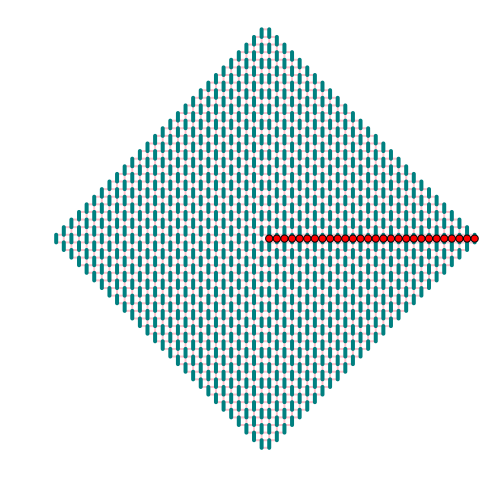

In [5]:
p = plot_generate(500)
plot!(grid=false)
plot_edges(p,az_lat_full)
plot!(grid=false, axis=false)

# config_hori = generate_config_hori(az_lat_full, az_lat_spin_full, spin_to_G)
config_vert = generate_config_vert(az_lat_full, az_lat_spin_full, spin_to_G)

plot_config(p, config_vert, spin_to_G, az_lat_full)

origin_pt = -0.5 + 0.0im
origin = index_pts(az_lat_spin_full.pts, origin_pt)
line = findall(x -> (abs(imag(x)) < 1e-5) && ( real(x) > real(origin_pt)), az_lat_spin.pts)

scatter!(real.(az_lat_spin_full.pts[line]), imag.(az_lat_spin_full.pts[line]), color=:red)
# savefig(p ,"./images/paper_images/az_random_config.pdf")

display(p)

# Monte Carlo

In [6]:
      
function sample_sz_line(running_sum::Vector{Int64}, config::Vector{Bool}, line::Vector{Int64}, nline::Int64)
    for i in 1:nline
        if @inbounds config[line[i]]
            @inbounds running_sum[i] = running_sum[i] + 1
        end
    end
end

function sample_szsz_line(running_sum::Vector{Int64}, config::Vector{Bool}, line::Vector{Int64}, nline::Int64, origin::Int64)
    if @inbounds config[origin] == 1
        for i in 1:nline
            if @inbounds config[line[i]]
                @inbounds running_sum[i] = running_sum[i] + 1
            end
        end
    end
end

sample_szsz_line (generic function with 1 method)

In [7]:
function mc(config::Vector{Bool}, plaq_sq_spin::Matrix{Int64}, line::Vector{Int64}, nsample::Int64, nwait::Int64,fname::String )
    Random.seed!(1234)
    nsq = size(plaq_sq_spin)[2]
    nspin = length(config)
    nline = length(line)
    sz = fill(0, length(line))
    szsz = fill(0, length(line))
    # f = open(fname,"w") 
    for i in 1:nsample
        for j in 1:nwait
            plaq_sq_move(config,plaq_sq_spin, nsq )
        end
        # write(f, config[line])
        # write(f, "\n")
        # Sample correlators

        sample_sz_line(sz, config, line, nline)
        sample_szsz_line(szsz, config, line, nline, 1) # 1 here is the origin index in the line
    end
    # close(f)
    sz = sz ./ nsample
    szsz = szsz ./ nsample
    return config, sz, szsz

end

mc (generic function with 1 method)

In [8]:
nwait = 1000
nsample = 1000_00


# Load lattice
N = 60
loaded_data = load("../data/aztec_lattices/" * string(N) * ".jld")

az_lat = loaded_data["az_lat"]
az_lat_spin = loaded_data["az_lat_spin"]
spin_to_G = loaded_data["spin_to_G"]
config_hori = loaded_data["config_hori"]
config_vert = loaded_data["config_vert"]

# config_hori = generate_config_hori(az_lat, az_lat_spin, spin_to_G)
# config_vert = generate_config_vert(az_lat, az_lat_spin, spin_to_G)

origin_pt = -0.5 + 0.0im
origin = index_pts(az_lat_spin.pts, origin_pt)
line_global = findall(x -> (abs(imag(x)) < 1e-5) && ( real(x) > real(origin_pt)), az_lat_spin.pts)

# fnames = ["../data/aztec_vert", "../data/aztec_hori"] .* "_" .* string(N)
fnames = ["nothing"," nothing"]
starting_config = [config_vert, config_hori]

data = []
for i in 1:length(fnames)
    line_local = line_global
    @time new_config, sz, szsz = mc(starting_config[i], az_lat_spin.sq_plaq, line_local, nsample, nwait, fnames[i])
    push!(data, (new_config, sz, szsz))
end


  0.992040 seconds (3.82 k allocations: 190.953 KiB, 0.83% compilation time)
  1.026306 seconds (16 allocations: 2.484 KiB)


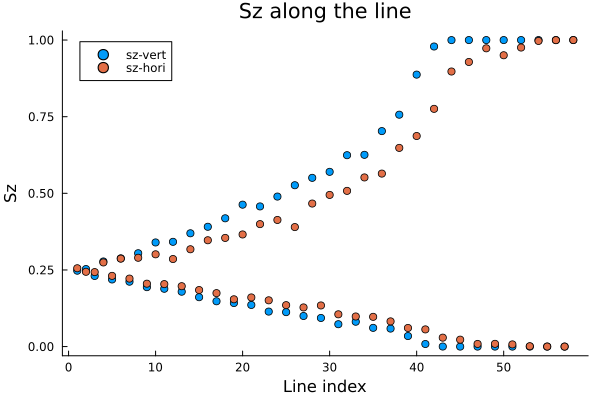

In [9]:
scatter(data[1][2], label="sz-vert", xlabel="Line index", ylabel="Sz", title="Sz along the line", legend=:topleft, grid=false)
scatter!(data[2][2], label="sz-hori", xlabel="Line index", ylabel="Sz", title="Sz along the line", legend=:topleft, grid=false)